In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import os

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Define the format
    handlers=[
        logging.FileHandler("system_log.log"),  # Save logs to a file
        logging.StreamHandler()  # Also display logs on the console
    ]
)

# Load the datasets
data_path = "../data/"

# Load only the first 1000 rows of each dataset

dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=3000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=3000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=3000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=3000)

# Concatenate datasets
#data = pd.concat([dos_data], axis=0)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Step 2: Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Step 3: Dynamically calculate the threshold based on the mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set threshold as mean + 2 standard deviations
threshold = mean_error + 2 * std_error
logging.info(f"Dynamically calculated threshold based on data: {threshold}")

# Function to detect anomalies and get their corresponding row indices
def detect_anomalies_with_indices(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    anomaly_indices = []  # List to store indices of the anomalies
    idx = 0  # Index counter for the data rows
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)  # Store the index of the anomaly
        idx += 1  # Increment index counter
    logging.info(f"Anomalies detected at rows (indices): {anomaly_indices}")
    return anomalies, anomaly_indices

# Detect anomalies and get their indices
anomalies, anomaly_indices = detect_anomalies_with_indices(dataloader, model, threshold)

# ==============================
# Mitigation Section with Logging
# ==============================

# A. Log Anomalies
def log_anomalies(anomaly_indices, reconstruction_errors, data):
    # Log anomalies with details
    with open("anomaly_log.txt", "w") as log_file:
        for idx in anomaly_indices:
            log_file.write(f"Anomaly at row {idx}, Error: {reconstruction_errors[idx]}, Data: {data[idx]}\n")
    logging.info("Anomalies logged.")

log_anomalies(anomaly_indices, reconstruction_errors, data_tensor)

# B. Alert Driver if critical anomaly is detected
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

# If critical anomaly is detected (e.g., anomaly in sensor data, ECU data), alert driver
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}")

# C. Isolate the ECU if compromised (pseudo-code)
def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} is isolated due to suspicious activity.")

# Example: Isolate a specific ECU if anomaly is related to that ECU (replace 'ecu_id' with real data)
isolate_ecu('ECU_1')

# D. Trigger Safe Mode in case of critical failure
def trigger_safe_mode():
    logging.critical("Entering safe mode due to anomaly detection...")

# Trigger safe mode for severe anomalies
if len(anomaly_indices) > 5:  # Example condition: more than 5 anomalies trigger safe mode
    trigger_safe_mode()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Define the format
    handlers=[
        logging.FileHandler("system_log.log"),  # Save logs to a file
        logging.StreamHandler()  # Also display logs on the console
    ]
)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=3000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=3000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=3000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=3000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Step 2: Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Step 3: Dynamically calculate the threshold based on the mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set threshold as mean + 2 standard deviations
threshold = mean_error + 2 * std_error
logging.info(f"Dynamically calculated threshold based on data: {threshold}")

# Function to detect anomalies and get their corresponding row indices and reconstruction error values
def detect_anomalies_with_values(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    anomaly_indices = []  # List to store indices of the anomalies
    anomaly_values = []  # List to store reconstruction errors (anomaly values)
    idx = 0  # Index counter for the data rows
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_error = loss.item()  # Reconstruction error for this batch
        
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if reconstruction_error > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)  # Store the index of the anomaly
            anomaly_values.append(reconstruction_error)  # Store the value of the anomaly (reconstruction error)
        idx += 1  # Increment index counter
    
    logging.info(f"Anomalies detected at rows (indices): {anomaly_indices}")
    logging.info(f"Anomaly values (reconstruction errors): {anomaly_values}")
    return anomalies, anomaly_indices, anomaly_values

# Detect anomalies, their indices, and values
anomalies, anomaly_indices, anomaly_values = detect_anomalies_with_values(dataloader, model, threshold)

# Print the number of anomalies detected, their corresponding row indices, and their reconstruction error values
print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Anomalies detected at rows (indices): {anomaly_indices}")
print(f"Anomaly values (reconstruction errors): {anomaly_values}")

# ==============================
# Mitigation Section with Logging
# ==============================

# A. Log Anomalies
def log_anomalies(anomaly_indices, anomaly_values, data):
    # Log anomalies with details
    with open("anomaly_log.txt", "w") as log_file:
        for i, idx in enumerate(anomaly_indices):
            log_file.write(f"Anomaly at row {idx}, Error: {anomaly_values[i]}, Data: {data[idx]}\n")
    logging.info("Anomalies logged.")

log_anomalies(anomaly_indices, anomaly_values, data_tensor)

# B. Alert Driver if critical anomaly is detected
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

# If critical anomaly is detected (e.g., anomaly in sensor data, ECU data), alert driver
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}")

# C. Isolate the ECU if compromised (pseudo-code)
def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} is isolated due to suspicious activity.")

# Example: Isolate a specific ECU if anomaly is related to that ECU (replace 'ecu_id' with real data)
isolate_ecu('ECU_1')

# D. Trigger Safe Mode in case of critical failure
def trigger_safe_mode():
    logging.critical("Entering safe mode due to anomaly detection...")

# Trigger safe mode for severe anomalies
if len(anomaly_indices) > 5:  # Example condition: more than 5 anomalies trigger safe mode
    trigger_safe_mode()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
from fastapi import FastAPI

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),  # Save logs to a file
        logging.StreamHandler()  # Also display logs on the console
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
dos_data = pd.read_csv('path_to_DoS_dataset.csv')
fuzzy_data = pd.read_csv('path_to_Fuzzy_dataset.csv')
gear_data = pd.read_csv('path_to_gear_dataset.csv')
rpm_data = pd.read_csv('path_to_RPM_dataset.csv')

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Calculate the threshold based on mean + 2 standard deviations of the reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
threshold = mean_error + 2 * std_error
logging.info(f"Dynamically calculated threshold: {threshold}")

# Function to detect anomalies with values
def detect_anomalies_with_values(data_loader, model, threshold):
    model.eval()
    anomalies = []
    anomaly_indices = []  # Store indices of anomalies
    anomaly_values = []  # Store reconstruction error values of anomalies
    idx = 0
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_error = loss.item()
        
        # If the reconstruction error exceeds the threshold, flag it as an anomaly
        if reconstruction_error > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)
            anomaly_values.append(reconstruction_error)
        idx += 1
    
    logging.info(f"Anomalies detected at rows: {anomaly_indices}")
    logging.info(f"Reconstruction error values of anomalies: {anomaly_values}")
    return anomalies, anomaly_indices, anomaly_values

# Detect anomalies and their values
anomalies, anomaly_indices, anomaly_values = detect_anomalies_with_values(dataloader, model, threshold)

# ==============================
# Real-Time Monitoring Simulation
# ==============================
def real_time_monitoring(data_loader, model, threshold):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        # Log every batch in real-time
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        # If the error exceeds the threshold, trigger an alert
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            alert_driver(f"Real-time anomaly detected with error {reconstruction_error}")
            isolate_ecu('ECU_X')  # Simulate ECU isolation
        time.sleep(1)  # Simulate real-time delay

# Simulate real-time monitoring
real_time_monitoring(dataloader, model, threshold)

# ==============================
# FastAPI REST API for Real-Time Anomaly Detection
# ==============================
app = FastAPI()

@app.post("/predict")
async def predict(data: list):
    input_tensor = torch.tensor(data, dtype=torch.float32)
    model.eval()
    output = model(input_tensor)
    reconstruction_error = criterion(output, input_tensor).item()

    # Check if it's an anomaly
    is_anomaly = reconstruction_error > threshold

    return {"reconstruction_error": reconstruction_error, "is_anomaly": is_anomaly}

# ==============================
# Mitigation Functions
# ==============================
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")

def trigger_safe_mode():
    logging.critical("Safe mode activated due to critical anomaly detection.")


2024-09-23 14:06:43,571 - INFO - Data loaded and concatenated. Total rows: 4000, Total columns: 32
2024-09-23 14:06:43,700 - INFO - Data preprocessing complete. Shape after preprocessing: (4000, 1665)
2024-09-23 14:06:43,880 - INFO - DataLoader created with batch size 64.
2024-09-23 14:06:43,892 - INFO - Autoencoder initialized with input size 1665.
2024-09-23 14:06:46,005 - INFO - Epoch 1/50, Loss: 0.010443628765642643
2024-09-23 14:06:46,333 - INFO - Epoch 2/50, Loss: 0.00944678857922554
2024-09-23 14:06:46,626 - INFO - Epoch 3/50, Loss: 0.009716537781059742
2024-09-23 14:06:46,967 - INFO - Epoch 4/50, Loss: 0.011124125681817532
2024-09-23 14:06:47,237 - INFO - Epoch 5/50, Loss: 0.007170554716140032
2024-09-23 14:06:47,515 - INFO - Epoch 6/50, Loss: 0.008277480490505695
2024-09-23 14:06:47,808 - INFO - Epoch 7/50, Loss: 0.009305828250944614
2024-09-23 14:06:48,118 - INFO - Epoch 8/50, Loss: 0.007511995732784271
2024-09-23 14:06:48,481 - INFO - Epoch 9/50, Loss: 0.00704730860888958
20

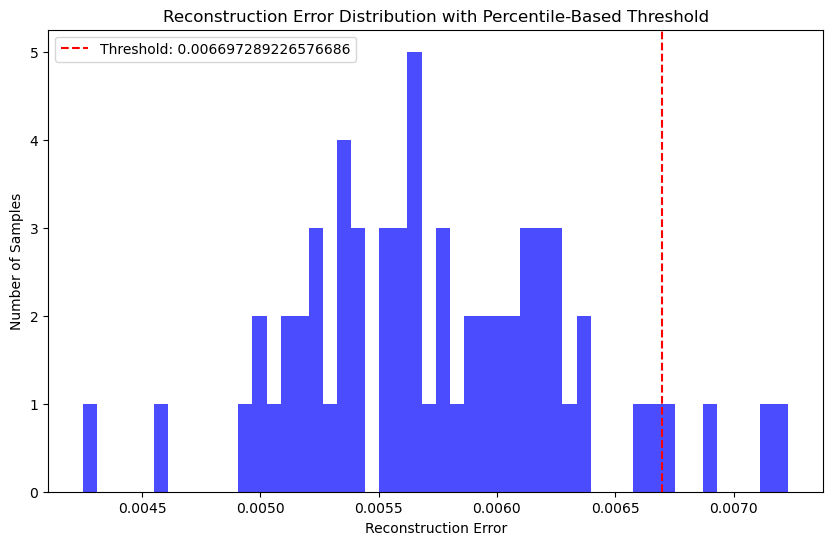

2024-09-23 14:07:16,035 - INFO - Anomalies detected at rows: [4, 19, 24, 35, 43, 44, 57]
2024-09-23 14:07:16,037 - INFO - Reconstruction error values of anomalies: [0.006826605647802353, 0.006811869330704212, 0.0072530112229287624, 0.007548198103904724, 0.007049527484923601, 0.0070543293841183186, 0.00726737454533577]
2024-09-23 14:07:16,040 - WARNING - Driver Alert: Critical anomaly detected at row 4, reconstruction error: 0.006826605647802353
2024-09-23 14:07:16,041 - WARNING - Driver Alert: Critical anomaly detected at row 19, reconstruction error: 0.006811869330704212
2024-09-23 14:07:16,042 - WARNING - Driver Alert: Critical anomaly detected at row 24, reconstruction error: 0.0072530112229287624
2024-09-23 14:07:16,044 - WARNING - Driver Alert: Critical anomaly detected at row 35, reconstruction error: 0.007548198103904724
2024-09-23 14:07:16,045 - WARNING - Driver Alert: Critical anomaly detected at row 43, reconstruction error: 0.007049527484923601
2024-09-23 14:07:16,047 - WARN

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
import os
import matplotlib.pyplot as plt

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Visualization of Reconstruction Errors
# ==============================
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
plt.title('Reconstruction Error Distribution with Percentile-Based Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

# ==============================
# Anomaly Detection with Percentile-Based Threshold
# ==============================
def detect_anomalies_with_values(data_loader, model, threshold):
    model.eval()
    anomalies = []
    anomaly_indices = []
    anomaly_values = []
    idx = 0
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_error = loss.item()
        
        if reconstruction_error > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)
            anomaly_values.append(reconstruction_error)
        idx += 1
    
    logging.info(f"Anomalies detected at rows: {anomaly_indices}")
    logging.info(f"Reconstruction error values of anomalies: {anomaly_values}")
    return anomalies, anomaly_indices, anomaly_values

# Detect anomalies and their values based on the threshold
anomalies, anomaly_indices, anomaly_values = detect_anomalies_with_values(dataloader, model, threshold)

# ==============================
# Mitigation Process
# ==============================
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")

def trigger_safe_mode():
    logging.critical("Safe mode activated due to critical anomaly detection.")

# A. Alert the driver for each detected anomaly
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}, reconstruction error: {anomaly_values[anomaly_indices.index(idx)]}")

# B. Isolate the ECU if anomalies are detected
if len(anomaly_indices) > 0:
    isolate_ecu('ECU_1')

# C. Trigger safe mode if too many anomalies are detected
if len(anomaly_indices) > 5:
    trigger_safe_mode()

# ==============================
# Real-Time Monitoring Simulation
# ==============================
def real_time_monitoring(data_loader, model, threshold):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            alert_driver(f"Real-time anomaly detected with error {reconstruction_error}")
            isolate_ecu('ECU_1')
        time.sleep(1)

# Simulate real-time monitoring
real_time_monitoring(dataloader, model, threshold)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import matplotlib.pyplot as plt
from fastapi import FastAPI
import uvicorn
import time
import os

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# ==============================
# Load the datasets (replace 'path_to_*' with actual file paths)
# ==============================
data_path = './data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=3000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=3000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=3000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=3000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Visualization of Reconstruction Errors
# ==============================
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
plt.title('Reconstruction Error Distribution with Percentile-Based Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

# ==============================
# Anomaly Detection with Percentile-Based Threshold
# ==============================
def detect_anomalies_with_values(data_loader, model, threshold):
    model.eval()
    anomalies = []
    anomaly_indices = []
    anomaly_values = []
    idx = 0
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_error = loss.item()
        
        if reconstruction_error > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)
            anomaly_values.append(reconstruction_error)
        idx += 1
    
    logging.info(f"Anomalies detected at rows: {anomaly_indices}")
    logging.info(f"Reconstruction error values of anomalies: {anomaly_values}")
    return anomalies, anomaly_indices, anomaly_values

# Detect anomalies and their values based on the threshold
anomalies, anomaly_indices, anomaly_values = detect_anomalies_with_values(dataloader, model, threshold)

# ==============================
# Mitigation Process
# ==============================
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")

def trigger_safe_mode():
    logging.critical("Safe mode activated due to critical anomaly detection.")

# A. Alert the driver for each detected anomaly
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}, reconstruction error: {anomaly_values[anomaly_indices.index(idx)]}")

# B. Isolate the ECU if anomalies are detected
if len(anomaly_indices) > 0:
    isolate_ecu('ECU_1')

# C. Trigger safe mode if too many anomalies are detected
if len(anomaly_indices) > 5:
    trigger_safe_mode()

# ==============================
# Real-Time Monitoring Simulation
# ==============================
def real_time_monitoring(data_loader, model, threshold):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            alert_driver(f"Real-time anomaly detected with error {reconstruction_error}")
            isolate_ecu('ECU_1')
        time.sleep(1)

# Simulate real-time monitoring
real_time_monitoring(dataloader, model, threshold)

# ==============================
# FastAPI Integration for Real-Time Predictions
# ==============================
app = FastAPI()

@app.post("/predict")
async def predict(data: list):
    input_tensor = torch.tensor(data, dtype=torch.float32)
    model.eval()
    output = model(input_tensor)
    reconstruction_error = criterion(output, input_tensor).item()

    # Check if it's an anomaly
    is_anomaly = reconstruction_error > threshold
    return {"reconstruction_error": reconstruction_error, "is_anomaly": is_anomaly}

# Run FastAPI with: uvicorn app:app --reload
